# C23-PR588 AUD/IDR DNN MODEL (ANOTHER)

Import necessary libraries

In [1]:
%run helper_functions_and_libraries.py
logging.set_verbosity(logging.ERROR)

Begin by looking at the structure of the csv that contains the data:

In [2]:
CURRENCIES_CSV = './currency_data_10_years.csv'

# Create dataframe by using datas from csv file
currencies_df = pd.read_csv(CURRENCIES_CSV)

# Create new dataframe containing ONLY needed data for the model
aud_idr_df = currencies_df[['date', 'AUD']]

# Displaying the first and last 5 row of data to understand the contents of the data
display(aud_idr_df.head())
display(aud_idr_df.tail())

,date,AUD
0,2013-05-01,9991.932116
1,2013-05-02,9976.629029
2,2013-05-03,10024.671009
3,2013-05-04,10037.051582
4,2013-05-05,9999.337595


,date,AUD
3648,2023-04-27,9743.131115
3649,2023-04-28,9706.330826
3650,2023-04-29,9696.280669
3651,2023-04-30,9699.881962
3652,2023-05-01,9719.609412


Each data point is composed of the date and the recorded exchange rate from AUD to IDR

## Parsing the raw data
Read the data from the csv file and Creating global (G) dataclass

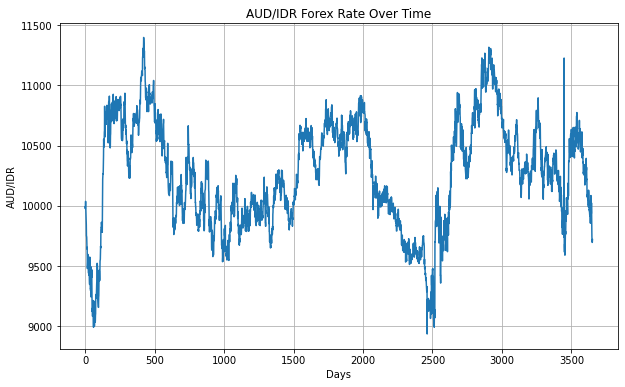

In [3]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    
    DATAFRAME = aud_idr_df
    times, values = parse_data_from_df(DATAFRAME, 'AUD')
    TIME = times
    SERIES = values
    SPLIT_TIME = int(math.floor(len(values)*0.8))
    WINDOW_SIZE = 30
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, title="AUD/IDR Forex Rate Over Time", xlabel="Days", ylabel="AUD/IDR")

## Processing the data

train_val_split and windowed_dataset functions taken from 'tensorflow-sequences-time-series-and-prediction' courses in Coursera

In [4]:
# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES, G.SPLIT_TIME, None)

In [5]:
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)
valid_set = windowed_dataset(series_valid, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosi

## Defining the model architecture

Using 5 layers model

In [6]:
def create_model_5_layers():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(256, input_shape=[G.WINDOW_SIZE], activation="relu"),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1)

    ], name="model_5_layers")

    return model

In [7]:
# Create and test model
model_1 = create_model_5_layers()

# Get initial weights
init_weights = model_1.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_1.set_weights(init_weights)

# Print the model summary
model_1.summary()

Model: "model_5_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               7936      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 51,201
Trainable params: 51,201
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

In [8]:
def compile_model(dataset, model_to_train):

    model = model_to_train
    
    # Select optimizer
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=['mae'])
    
    # Train the model
    history = model.fit(dataset,
                        epochs=100, 
                        verbose=1,
                        batch_size=G.BATCH_SIZE,
                        validation_data=valid_set,
                        callbacks=[create_model_checkpoint(save_path='experiments')])

    return history

# Run the training with dynamic LR
history_1 = compile_model(train_set, model_1)

Epoch 1/100
     66/Unknown - 1s 4ms/step - loss: 854.3087 - mae: 854.8086  INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 4s 29ms/step - loss: 668.6523 - mae: 669.1518 - val_loss: 226.4508 - val_mae: 226.9507
Epoch 2/100
91/91 [==============================] - 1s 4ms/step - loss: 144.9034 - mae: 145.4026 - val_loss: 250.0482 - val_mae: 250.5482
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 158.1465 - mae: 158.6462INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 157.9028 - mae: 158.4026 - val_loss: 192.3944 - val_mae: 192.8942
Epoch 4/100
89/91 [============================>.] - ETA: 0s - loss: 140.4770 - mae: 140.9765INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 12ms/step - loss: 140.4242 - mae: 140.9237 - val_loss: 135.2175 - val_mae: 135.7175
Epoch 5/100
91/91 [==============================] - 1s 4ms/step - loss: 134.3536 - mae: 134.8529 - val_loss: 149.2887 - val_mae: 149.7887
Epoch 6/100
89/91 [============================>.] - ETA: 0s - loss: 142.9882 - mae: 143.4876INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 142.6582 - mae: 143.1577 - val_loss: 101.0104 - val_mae: 101.5087
Epoch 7/100
91/91 [==============================] - 1s 5ms/step - loss: 134.0853 - mae: 134.5848 - val_loss: 114.0883 - val_mae: 114.5877
Epoch 8/100
91/91 [==============================] - 1s 4ms/step - loss: 127.5491 - mae: 128.0475 - val_loss: 116.2392 - val_mae: 116.7388
Epoch 9/100
91/91 [==============================] - 1s 5ms/step - loss: 137.8285 - mae: 138.3281 - val_loss: 110.5312 - val_mae: 111.0303
Epoch 10/100
91/91 [==============================] - 1s 4ms/step - loss: 126.7748 - mae: 127.2739 - val_loss: 186.7305 - val_mae: 187.2305
Epoch 11/100
91/91 [==============================] - 1s 4ms/step - loss: 143.3925 - mae: 143.8919 - val_loss: 159.9691 - val_mae: 160.4691
Epoch 12/100
91/91 [==============================] - 1s 4ms/step - loss: 122.1103 - mae: 122.6100 - val_loss: 227.8465 - val_mae: 228.3465
Epoch 13/100
91/91 [===============

INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 115.2839 - mae: 115.7829 - val_loss: 96.2392 - val_mae: 96.7382
Epoch 16/100
83/91 [==========================>...] - ETA: 0s - loss: 126.7227 - mae: 127.2215INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 14ms/step - loss: 126.2162 - mae: 126.7151 - val_loss: 84.3140 - val_mae: 84.8133
Epoch 17/100
85/91 [===========================>..] - ETA: 0s - loss: 113.2215 - mae: 113.7201INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 2s 17ms/step - loss: 111.3880 - mae: 111.8866 - val_loss: 82.3058 - val_mae: 82.8046
Epoch 18/100
91/91 [==============================] - 1s 5ms/step - loss: 105.6959 - mae: 106.1953 - val_loss: 161.1821 - val_mae: 161.6819
Epoch 19/100
91/91 [==============================] - 1s 6ms/step - loss: 128.6875 - mae: 129.1864 - val_loss: 122.5666 - val_mae: 123.0654
Epoch 20/100
91/91 [==============================] - 1s 5ms/step - loss: 136.2055 - mae: 136.7041 - val_loss: 124.8210 - val_mae: 125.3207
Epoch 21/100
91/91 [==============================] - 1s 5ms/step - loss: 97.8871 - mae: 98.3853 - val_loss: 100.5291 - val_mae: 101.0285
Epoch 22/100
91/91 [==============================] - 1s 5ms/step - loss: 104.7673 - mae: 105.2665 - val_loss: 89.8108 - val_mae: 90.3097
Epoch 23/100
91/91 [==============================] - 1s 5ms/step - loss: 112.8922 - mae: 113.3916 - val_loss: 239.2075 - val_mae: 239.7075
Epoch 24/100
91/91 [==================

INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 15ms/step - loss: 109.0957 - mae: 109.5949 - val_loss: 77.3896 - val_mae: 77.8885
Epoch 27/100
91/91 [==============================] - 1s 5ms/step - loss: 127.5949 - mae: 128.0941 - val_loss: 108.1519 - val_mae: 108.6515
Epoch 28/100
91/91 [==============================] - 1s 5ms/step - loss: 145.0483 - mae: 145.5474 - val_loss: 91.8374 - val_mae: 92.3354
Epoch 29/100
91/91 [==============================] - 1s 5ms/step - loss: 102.9008 - mae: 103.4002 - val_loss: 153.9408 - val_mae: 154.4408
Epoch 30/100
91/91 [==============================] - ETA: 0s - loss: 105.1103 - mae: 105.6091INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 14ms/step - loss: 105.1103 - mae: 105.6091 - val_loss: 76.3580 - val_mae: 76.8566
Epoch 31/100
91/91 [==============================] - 1s 5ms/step - loss: 118.4669 - mae: 118.9661 - val_loss: 112.6055 - val_mae: 113.1051
Epoch 32/100
91/91 [==============================] - 1s 4ms/step - loss: 113.9848 - mae: 114.4840 - val_loss: 177.6319 - val_mae: 178.1318
Epoch 33/100
91/91 [==============================] - 1s 5ms/step - loss: 185.1300 - mae: 185.6297 - val_loss: 109.7397 - val_mae: 110.2389
Epoch 34/100
91/91 [==============================] - 1s 4ms/step - loss: 102.6061 - mae: 103.1050 - val_loss: 144.5511 - val_mae: 145.0504
Epoch 35/100
82/91 [==========================>...] - ETA: 0s - loss: 100.0534 - mae: 100.5522INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 100.5269 - mae: 101.0258 - val_loss: 75.3784 - val_mae: 75.8767
Epoch 36/100
83/91 [==========================>...] - ETA: 0s - loss: 83.9761 - mae: 84.4740INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 14ms/step - loss: 86.3157 - mae: 86.8137 - val_loss: 74.0392 - val_mae: 74.5391
Epoch 37/100
91/91 [==============================] - 1s 5ms/step - loss: 114.9629 - mae: 115.4621 - val_loss: 74.0555 - val_mae: 74.5539
Epoch 38/100
91/91 [==============================] - 1s 4ms/step - loss: 99.3712 - mae: 99.8704 - val_loss: 189.2240 - val_mae: 189.7237
Epoch 39/100
85/91 [===========================>..] - ETA: 0s - loss: 105.1382 - mae: 105.6375INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 12ms/step - loss: 103.3239 - mae: 103.8233 - val_loss: 71.8916 - val_mae: 72.3908
Epoch 40/100
91/91 [==============================] - 1s 5ms/step - loss: 105.7566 - mae: 106.2561 - val_loss: 73.9780 - val_mae: 74.4761
Epoch 41/100
91/91 [==============================] - 1s 5ms/step - loss: 92.7522 - mae: 93.2512 - val_loss: 150.0522 - val_mae: 150.5518
Epoch 42/100
91/91 [==============================] - 1s 4ms/step - loss: 96.2097 - mae: 96.7086 - val_loss: 110.6944 - val_mae: 111.1943
Epoch 43/100
91/91 [==============================] - 1s 4ms/step - loss: 135.9176 - mae: 136.4171 - val_loss: 149.2764 - val_mae: 149.7759
Epoch 44/100
91/91 [==============================] - 1s 4ms/step - loss: 106.3461 - mae: 106.8451 - val_loss: 110.5509 - val_mae: 111.0503
Epoch 45/100
91/91 [==============================] - 1s 5ms/step - loss: 98.8871 - mae: 99.3861 - val_loss: 128.2353 - val_mae: 128.7346
Epoch 46/100
91/91 [======================

INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 12ms/step - loss: 106.2851 - mae: 106.7838 - val_loss: 70.5410 - val_mae: 71.0400
Epoch 49/100
91/91 [==============================] - 1s 4ms/step - loss: 91.2982 - mae: 91.7971 - val_loss: 74.4193 - val_mae: 74.9178
Epoch 50/100
91/91 [==============================] - 1s 4ms/step - loss: 91.0974 - mae: 91.5966 - val_loss: 105.0430 - val_mae: 105.5417
Epoch 51/100
91/91 [==============================] - 1s 4ms/step - loss: 97.9442 - mae: 98.4420 - val_loss: 84.7627 - val_mae: 85.2625
Epoch 52/100
91/91 [==============================] - 1s 5ms/step - loss: 104.3526 - mae: 104.8520 - val_loss: 73.2182 - val_mae: 73.7156
Epoch 53/100
91/91 [==============================] - 1s 4ms/step - loss: 88.8955 - mae: 89.3936 - val_loss: 101.9789 - val_mae: 102.4779
Epoch 54/100
91/91 [==============================] - 1s 4ms/step - loss: 101.0908 - mae: 101.5893 - val_loss: 124.4841 - val_mae: 124.9836
Epoch 55/100
91/91 [============================

INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 14ms/step - loss: 93.5189 - mae: 94.0178 - val_loss: 67.7688 - val_mae: 68.2663
Epoch 65/100
85/91 [===========================>..] - ETA: 0s - loss: 89.4087 - mae: 89.9080INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 89.3945 - mae: 89.8938 - val_loss: 67.4835 - val_mae: 67.9810
Epoch 66/100
91/91 [==============================] - 1s 4ms/step - loss: 85.8100 - mae: 86.3083 - val_loss: 115.1289 - val_mae: 115.6285
Epoch 67/100
91/91 [==============================] - 1s 5ms/step - loss: 94.8549 - mae: 95.3545 - val_loss: 112.3744 - val_mae: 112.8743
Epoch 68/100
91/91 [==============================] - 1s 5ms/step - loss: 85.3314 - mae: 85.8302 - val_loss: 199.5221 - val_mae: 200.0221
Epoch 69/100
91/91 [==============================] - 1s 5ms/step - loss: 92.9643 - mae: 93.4633 - val_loss: 69.0149 - val_mae: 69.5116
Epoch 70/100
91/91 [==============================] - 1s 5ms/step - loss: 88.9206 - mae: 89.4193 - val_loss: 75.9316 - val_mae: 76.4290
Epoch 71/100
86/91 [===========================>..] - ETA: 0s - loss: 93.6222 - mae: 94.1213INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 93.1033 - mae: 93.6026 - val_loss: 66.4144 - val_mae: 66.9122
Epoch 72/100
91/91 [==============================] - 1s 4ms/step - loss: 87.6249 - mae: 88.1236 - val_loss: 74.4154 - val_mae: 74.9134
Epoch 73/100
91/91 [==============================] - 1s 5ms/step - loss: 84.8694 - mae: 85.3675 - val_loss: 79.1291 - val_mae: 79.6260
Epoch 74/100
86/91 [===========================>..] - ETA: 0s - loss: 80.8734 - mae: 81.3719INFO:tensorflow:Assets written to: experiments/3\assets


INFO:tensorflow:Assets written to: experiments/3\assets


91/91 [==============================] - 1s 13ms/step - loss: 81.7128 - mae: 82.2111 - val_loss: 65.6418 - val_mae: 66.1408
Epoch 75/100
91/91 [==============================] - 1s 5ms/step - loss: 85.7133 - mae: 86.2115 - val_loss: 71.3476 - val_mae: 71.8468
Epoch 76/100
91/91 [==============================] - 1s 4ms/step - loss: 100.1043 - mae: 100.6035 - val_loss: 106.9454 - val_mae: 107.4453
Epoch 77/100
91/91 [==============================] - 1s 5ms/step - loss: 90.7192 - mae: 91.2181 - val_loss: 65.7030 - val_mae: 66.2027
Epoch 78/100
91/91 [==============================] - 1s 4ms/step - loss: 84.0315 - mae: 84.5297 - val_loss: 78.1282 - val_mae: 78.6255
Epoch 79/100
91/91 [==============================] - 1s 5ms/step - loss: 85.6141 - mae: 86.1125 - val_loss: 104.2878 - val_mae: 104.7874
Epoch 80/100
91/91 [==============================] - 1s 5ms/step - loss: 84.7849 - mae: 85.2839 - val_loss: 145.0874 - val_mae: 145.5874
Epoch 81/100
91/91 [==============================] 

## Visualize MAE and loss

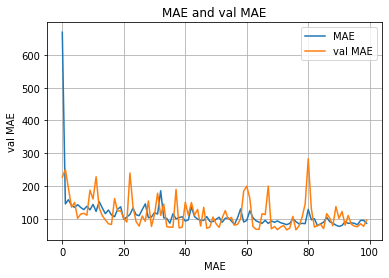

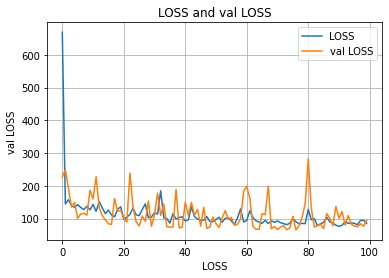

In [9]:
visualize_mae_loss(history_1)

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 0s 4ms/step


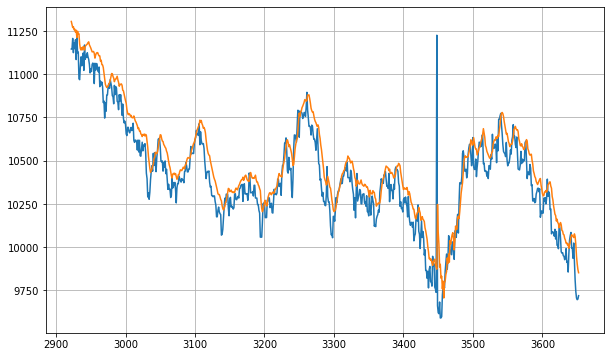

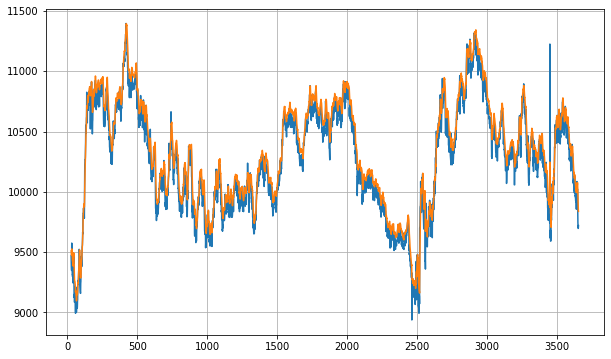

In [10]:
dnn_forecast_model_1 = evaluate_forecast(model_1, G.TIME, G.SERIES, time_valid, series_valid,
                                       G.SPLIT_TIME, -1, G.WINDOW_SIZE, G.BATCH_SIZE)

In [11]:
metrics_model_1 = compute_metrics(series_valid, dnn_forecast_model_1)
metrics_model_1

{'mae': 338.23752, 'mse': 186806.88, 'rmse': 410.37692, 'mape': 3.2603638}

In [12]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_model_1[-2:]}')

2 last Actual Price = [[9699.881962]
 [9719.609412]], Predicted Price = [9871.066 9852.367]


## Defining the model architecture

Using 4 layers model with regularizers

In [13]:
def create_model_regularized_4_layers():
    
    # Build the model
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(128, input_shape=[G.WINDOW_SIZE], activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)

    ], name="model_regularized_4_layers")

    return model

In [14]:
# Create and test model
model_2 = create_model_regularized_4_layers()

# Get initial weights
init_weights = model_2.get_weights()

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_2.set_weights(init_weights)

# Print the model summary
model_2.summary()

Model: "model_regularized_4_layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14,337
Trainable params: 14,337
Non-trainable params: 0
_________________________________________________________________


## Compiling the model

In [15]:
# Run the training with dynamic LR
history_2 = compile_model(train_set, model_2)

Epoch 1/100
     80/Unknown - 1s 3ms/step - loss: 1351.4404 - mae: 1350.6216INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 3s 18ms/step - loss: 1214.2732 - mae: 1213.4905 - val_loss: 207.1740 - val_mae: 206.6957
Epoch 2/100
78/91 [========================>.....] - ETA: 0s - loss: 145.1864 - mae: 144.7997INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 14ms/step - loss: 147.0102 - mae: 146.6324 - val_loss: 127.9355 - val_mae: 127.6189
Epoch 3/100
90/91 [============================>.] - ETA: 0s - loss: 125.5997 - mae: 125.3015INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 125.6073 - mae: 125.3091 - val_loss: 111.1914 - val_mae: 110.9040
Epoch 4/100
91/91 [==============================] - 1s 5ms/step - loss: 119.5736 - mae: 119.2889 - val_loss: 126.4096 - val_mae: 126.1264
Epoch 5/100
91/91 [==============================] - 1s 5ms/step - loss: 138.9692 - mae: 138.6878 - val_loss: 135.7121 - val_mae: 135.4317
Epoch 6/100
85/91 [===========================>..] - ETA: 0s - loss: 126.8195 - mae: 126.5397INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 14ms/step - loss: 125.5068 - mae: 125.2271 - val_loss: 97.1311 - val_mae: 96.8509
Epoch 7/100
91/91 [==============================] - 1s 5ms/step - loss: 180.9381 - mae: 180.6602 - val_loss: 98.5008 - val_mae: 98.2240
Epoch 8/100
91/91 [==============================] - 1s 4ms/step - loss: 124.2935 - mae: 124.0170 - val_loss: 149.7608 - val_mae: 149.4848
Epoch 9/100
91/91 [==============================] - 1s 5ms/step - loss: 128.6536 - mae: 128.3787 - val_loss: 112.7320 - val_mae: 112.4576
Epoch 10/100
91/91 [==============================] - 1s 4ms/step - loss: 142.7307 - mae: 142.4570 - val_loss: 110.6673 - val_mae: 110.3944
Epoch 11/100
91/91 [==============================] - 1s 4ms/step - loss: 131.3486 - mae: 131.0760 - val_loss: 124.4291 - val_mae: 124.1564
Epoch 12/100
91/91 [==============================] - 1s 5ms/step - loss: 110.1940 - mae: 109.9220 - val_loss: 110.4298 - val_mae: 110.1586
Epoch 13/100
91/91 [===================

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 2s 16ms/step - loss: 113.0534 - mae: 112.7815 - val_loss: 94.6338 - val_mae: 94.3611
Epoch 15/100
76/91 [========================>.....] - ETA: 0s - loss: 107.9503 - mae: 107.6781INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 14ms/step - loss: 106.9295 - mae: 106.6571 - val_loss: 89.3939 - val_mae: 89.1206
Epoch 16/100
91/91 [==============================] - 1s 4ms/step - loss: 103.8516 - mae: 103.5782 - val_loss: 129.7612 - val_mae: 129.4881
Epoch 17/100
62/91 [===================>..........] - ETA: 0s - loss: 98.1505 - mae: 97.8783INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 100.4826 - mae: 100.2100 - val_loss: 83.7504 - val_mae: 83.4794
Epoch 18/100
60/91 [==================>...........] - ETA: 0s - loss: 90.5562 - mae: 90.2841 INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 14ms/step - loss: 101.8419 - mae: 101.5701 - val_loss: 82.0486 - val_mae: 81.7774
Epoch 19/100
91/91 [==============================] - 1s 4ms/step - loss: 100.8631 - mae: 100.5926 - val_loss: 100.2515 - val_mae: 99.9824
Epoch 20/100
61/91 [===================>..........] - ETA: 0s - loss: 97.5209 - mae: 97.2516  INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 96.9298 - mae: 96.6605 - val_loss: 78.9757 - val_mae: 78.7071
Epoch 21/100
91/91 [==============================] - 1s 4ms/step - loss: 100.3331 - mae: 100.0648 - val_loss: 92.4887 - val_mae: 92.2203
Epoch 22/100
72/91 [======================>.......] - ETA: 0s - loss: 105.4499 - mae: 105.1829INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 101.0164 - mae: 100.7495 - val_loss: 76.5563 - val_mae: 76.2887
Epoch 23/100
91/91 [==============================] - 1s 4ms/step - loss: 98.5208 - mae: 98.2551 - val_loss: 270.9393 - val_mae: 270.6750
Epoch 24/100
91/91 [==============================] - 1s 4ms/step - loss: 112.7062 - mae: 112.4412 - val_loss: 84.0590 - val_mae: 83.7935
Epoch 25/100
61/91 [===================>..........] - ETA: 0s - loss: 106.1996 - mae: 105.9359INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 100.9125 - mae: 100.6486 - val_loss: 75.3392 - val_mae: 75.0743
Epoch 26/100
91/91 [==============================] - 1s 4ms/step - loss: 92.2151 - mae: 91.9518 - val_loss: 173.8104 - val_mae: 173.5488
Epoch 27/100
91/91 [==============================] - 0s 4ms/step - loss: 120.6578 - mae: 120.3965 - val_loss: 183.2881 - val_mae: 183.0276
Epoch 28/100
91/91 [==============================] - 1s 4ms/step - loss: 97.4046 - mae: 97.1441 - val_loss: 133.2355 - val_mae: 132.9759
Epoch 29/100
91/91 [==============================] - 1s 4ms/step - loss: 109.2120 - mae: 108.9518 - val_loss: 75.4298 - val_mae: 75.1703
Epoch 30/100
91/91 [==============================] - 1s 4ms/step - loss: 91.2247 - mae: 90.9654 - val_loss: 89.1314 - val_mae: 88.8727
Epoch 31/100
91/91 [==============================] - 1s 4ms/step - loss: 97.2903 - mae: 97.0321 - val_loss: 131.4159 - val_mae: 131.1595
Epoch 32/100
91/91 [==========================

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 94.1907 - mae: 93.9342 - val_loss: 74.1189 - val_mae: 73.8622
Epoch 34/100
60/91 [==================>...........] - ETA: 0s - loss: 82.2168 - mae: 81.9604INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 87.5993 - mae: 87.3427 - val_loss: 72.3914 - val_mae: 72.1352
Epoch 35/100
91/91 [==============================] - 0s 4ms/step - loss: 85.1780 - mae: 84.9233 - val_loss: 73.9522 - val_mae: 73.6970
Epoch 36/100
91/91 [==============================] - 1s 4ms/step - loss: 90.9772 - mae: 90.7233 - val_loss: 79.7540 - val_mae: 79.4988
Epoch 37/100
91/91 [==============================] - 0s 4ms/step - loss: 100.0889 - mae: 99.8362 - val_loss: 76.7842 - val_mae: 76.5318
Epoch 38/100
59/91 [==================>...........] - ETA: 0s - loss: 82.8826 - mae: 82.6304INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 94.5516 - mae: 94.2996 - val_loss: 71.8265 - val_mae: 71.5736
Epoch 39/100
91/91 [==============================] - 0s 4ms/step - loss: 84.0211 - mae: 83.7705 - val_loss: 215.6693 - val_mae: 215.4202
Epoch 40/100
91/91 [==============================] - 1s 4ms/step - loss: 93.6368 - mae: 93.3870 - val_loss: 225.6077 - val_mae: 225.3596
Epoch 41/100
91/91 [==============================] - 0s 4ms/step - loss: 92.3864 - mae: 92.1381 - val_loss: 273.0571 - val_mae: 272.8100
Epoch 42/100
91/91 [==============================] - 1s 4ms/step - loss: 149.3494 - mae: 149.1030 - val_loss: 77.5720 - val_mae: 77.3260
Epoch 43/100
91/91 [==============================] - 0s 4ms/step - loss: 84.5647 - mae: 84.3193 - val_loss: 82.1354 - val_mae: 81.8910
Epoch 44/100
91/91 [==============================] - 1s 4ms/step - loss: 110.1364 - mae: 109.8917 - val_loss: 83.7028 - val_mae: 83.4559
Epoch 45/100
91/91 [==============================

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 14ms/step - loss: 109.6715 - mae: 109.4285 - val_loss: 71.2104 - val_mae: 70.9679
Epoch 47/100
91/91 [==============================] - 0s 4ms/step - loss: 91.0866 - mae: 90.8451 - val_loss: 104.4700 - val_mae: 104.2290
Epoch 48/100
91/91 [==============================] - 0s 4ms/step - loss: 106.6157 - mae: 106.3750 - val_loss: 108.1405 - val_mae: 107.9008
Epoch 49/100
91/91 [==============================] - 0s 4ms/step - loss: 80.9872 - mae: 80.7480 - val_loss: 73.8855 - val_mae: 73.6466
Epoch 50/100
91/91 [==============================] - 0s 4ms/step - loss: 79.9181 - mae: 79.6795 - val_loss: 100.7695 - val_mae: 100.5313
Epoch 51/100
91/91 [==============================] - 1s 4ms/step - loss: 95.2822 - mae: 95.0453 - val_loss: 113.7157 - val_mae: 113.4788
Epoch 52/100
91/91 [==============================] - ETA: 0s - loss: 81.1918 - mae: 80.9556INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 81.1918 - mae: 80.9556 - val_loss: 68.9057 - val_mae: 68.6710
Epoch 53/100
91/91 [==============================] - 1s 4ms/step - loss: 76.4271 - mae: 76.1911 - val_loss: 131.5511 - val_mae: 131.3176
Epoch 54/100
91/91 [==============================] - 1s 4ms/step - loss: 94.6797 - mae: 94.4458 - val_loss: 99.5745 - val_mae: 99.3426
Epoch 55/100
91/91 [==============================] - 1s 4ms/step - loss: 78.2186 - mae: 77.9856 - val_loss: 72.3687 - val_mae: 72.1373
Epoch 56/100
91/91 [==============================] - 1s 4ms/step - loss: 84.8563 - mae: 84.6254 - val_loss: 112.7316 - val_mae: 112.5017
Epoch 57/100
62/91 [===================>..........] - ETA: 0s - loss: 84.3079 - mae: 84.0787INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 86.6437 - mae: 86.4146 - val_loss: 67.6849 - val_mae: 67.4550
Epoch 58/100
91/91 [==============================] - 1s 4ms/step - loss: 86.7766 - mae: 86.5490 - val_loss: 76.3910 - val_mae: 76.1632
Epoch 59/100
91/91 [==============================] - 1s 4ms/step - loss: 86.7662 - mae: 86.5397 - val_loss: 90.7105 - val_mae: 90.4849
Epoch 60/100
91/91 [==============================] - 0s 4ms/step - loss: 88.9569 - mae: 88.7323 - val_loss: 97.6762 - val_mae: 97.4532
Epoch 61/100
91/91 [==============================] - 0s 4ms/step - loss: 78.5749 - mae: 78.3512 - val_loss: 75.6744 - val_mae: 75.4518
Epoch 62/100
91/91 [==============================] - 0s 4ms/step - loss: 79.6753 - mae: 79.4529 - val_loss: 81.8338 - val_mae: 81.6132
Epoch 63/100
91/91 [==============================] - 1s 4ms/step - loss: 78.7449 - mae: 78.5247 - val_loss: 69.0040 - val_mae: 68.7839
Epoch 64/100
91/91 [==============================] - 1s 4ms

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 77.8596 - mae: 77.6568 - val_loss: 66.0085 - val_mae: 65.8062
Epoch 74/100
91/91 [==============================] - 0s 4ms/step - loss: 76.9230 - mae: 76.7227 - val_loss: 83.0803 - val_mae: 82.8810
Epoch 75/100
91/91 [==============================] - 0s 4ms/step - loss: 80.5140 - mae: 80.3152 - val_loss: 88.1500 - val_mae: 87.9528
Epoch 76/100
91/91 [==============================] - 0s 4ms/step - loss: 76.8117 - mae: 76.6142 - val_loss: 162.0146 - val_mae: 161.8203
Epoch 77/100
91/91 [==============================] - 0s 4ms/step - loss: 81.1579 - mae: 80.9631 - val_loss: 130.9483 - val_mae: 130.7563
Epoch 78/100
91/91 [==============================] - 0s 4ms/step - loss: 77.8585 - mae: 77.6661 - val_loss: 123.6116 - val_mae: 123.4214
Epoch 79/100
91/91 [==============================] - 0s 4ms/step - loss: 85.6865 - mae: 85.4963 - val_loss: 109.6989 - val_mae: 109.5097
Epoch 80/100
91/91 [==============================] 

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 79.2492 - mae: 79.0716 - val_loss: 65.2910 - val_mae: 65.1145
Epoch 85/100
91/91 [==============================] - 0s 4ms/step - loss: 73.1294 - mae: 72.9537 - val_loss: 65.8984 - val_mae: 65.7250
Epoch 86/100
91/91 [==============================] - 0s 4ms/step - loss: 79.2238 - mae: 79.0504 - val_loss: 70.7757 - val_mae: 70.6026
Epoch 87/100
91/91 [==============================] - 1s 4ms/step - loss: 76.6547 - mae: 76.4842 - val_loss: 140.4133 - val_mae: 140.2447
Epoch 88/100
91/91 [==============================] - 0s 4ms/step - loss: 74.5375 - mae: 74.3698 - val_loss: 81.6668 - val_mae: 81.5007
Epoch 89/100
91/91 [==============================] - 0s 4ms/step - loss: 77.4243 - mae: 77.2592 - val_loss: 71.2917 - val_mae: 71.1277
Epoch 90/100
91/91 [==============================] - 0s 4ms/step - loss: 85.0462 - mae: 84.8843 - val_loss: 71.9859 - val_mae: 71.8223
Epoch 91/100
91/91 [==============================] - 1s 4

INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 13ms/step - loss: 79.6295 - mae: 79.4814 - val_loss: 64.8983 - val_mae: 64.7528
Epoch 96/100
62/91 [===================>..........] - ETA: 0s - loss: 82.5688 - mae: 82.4240INFO:tensorflow:Assets written to: experiments/4\assets


INFO:tensorflow:Assets written to: experiments/4\assets


91/91 [==============================] - 1s 12ms/step - loss: 80.1287 - mae: 79.9841 - val_loss: 64.7859 - val_mae: 64.6421
Epoch 97/100
91/91 [==============================] - 0s 4ms/step - loss: 76.2005 - mae: 76.0593 - val_loss: 65.0854 - val_mae: 64.9454
Epoch 98/100
91/91 [==============================] - 1s 5ms/step - loss: 77.3008 - mae: 77.1614 - val_loss: 120.3242 - val_mae: 120.1883
Epoch 99/100
91/91 [==============================] - 1s 4ms/step - loss: 96.5614 - mae: 96.4268 - val_loss: 169.6631 - val_mae: 169.5306
Epoch 100/100
91/91 [==============================] - 1s 4ms/step - loss: 78.0031 - mae: 77.8708 - val_loss: 67.0525 - val_mae: 66.9221


## Visualize MAE and loss

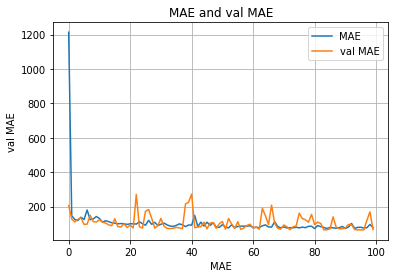

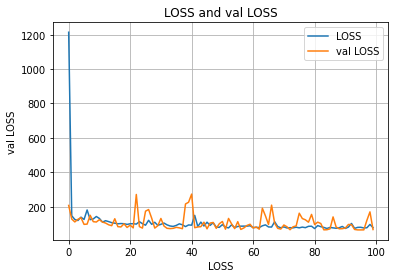

In [16]:
visualize_mae_loss(history_2)

## Evaluating the forecast

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
23/23 [==============================] - 0s 4ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '__dict__'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
114/114 [==============================] - 0s 4ms/step


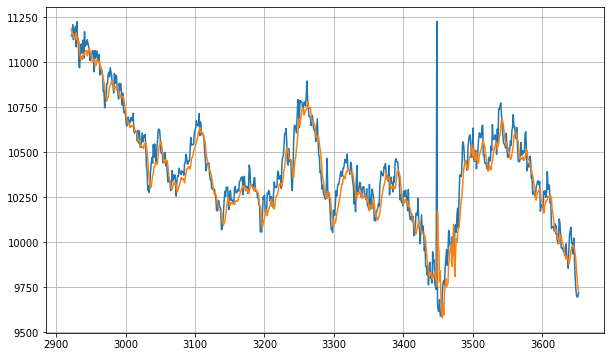

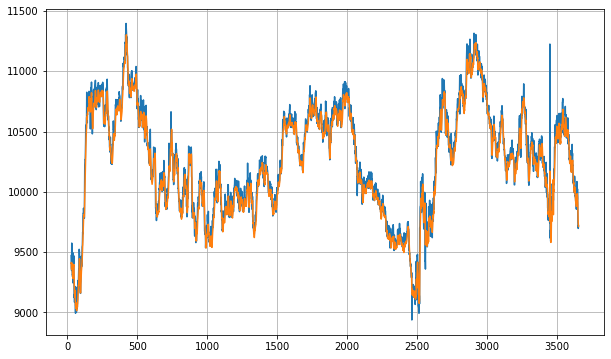

In [17]:
dnn_forecast_model_2 = evaluate_forecast(model_2, G.TIME, G.SERIES, time_valid, series_valid,
                                       G.SPLIT_TIME, -1, G.WINDOW_SIZE, G.BATCH_SIZE)

In [18]:
metrics_model_2 = compute_metrics(series_valid, dnn_forecast_model_2)
metrics_model_2

{'mae': 332.4346, 'mse': 180286.28, 'rmse': 401.4615, 'mape': 3.1879244}

In [19]:
print(f'2 last Actual Price = {series_valid[-2:]}, Predicted Price = {dnn_forecast_model_2[-2:]}')

2 last Actual Price = [[9699.881962]
 [9719.609412]], Predicted Price = [9748.586 9729.853]


## Future Predictions

Doing 1 week predictions

In [20]:
into_future = 7

future_forecast_model_1 = make_future_forecast(values=G.SERIES,
                                               model=model_1,
                                               into_future=into_future,
                                               window_size=G.WINDOW_SIZE)

future_forecast_model_2 = make_future_forecast(values=G.SERIES,
                                               model=model_2,
                                               into_future=into_future,
                                               window_size=G.WINDOW_SIZE)

1/1 [==============================] - 0s 34ms/step
Predicting on:
 [[ 9991.164594]
 [10129.656911]
 [10112.958701]
 [10052.054014]
 [ 9973.110625]
 [ 9965.620727]
 [ 9968.598951]
 [ 9950.687169]
 [ 9947.506228]
 [ 9927.536872]
 [ 9940.046811]
 [ 9991.557014]
 [ 9913.167687]
 [ 9917.60924 ]
 [ 9856.107891]
 [ 9961.256773]
 [10040.224458]
 [10066.447283]
 [10085.21644 ]
 [ 9995.16504 ]
 [ 9995.165155]
 [ 9935.947873]
 [10023.99686 ]
 [ 9915.824429]
 [ 9812.169065]
 [ 9743.131115]
 [ 9706.330826]
 [ 9696.280669]
 [ 9699.881962]
 [ 9719.609412]] -> Prediction: 9837.7880859375

1/1 [==============================] - 0s 64ms/step
Predicting on:
 [10129.656911   10112.958701   10052.054014    9973.110625
  9965.620727    9968.598951    9950.687169    9947.506228
  9927.536872    9940.046811    9991.557014    9913.167687
  9917.60924     9856.107891    9961.256773   10040.224458
 10066.447283   10085.21644     9995.16504     9995.165155
  9935.947873   10023.99686     9915.824429    9812.1690

In [21]:
start_future = G.TIME[-1] + 1
future_time = np.arange(start_future, start_future + into_future)

# Insert last timestep/final price into next time steps and future forecasts so the plot connects
future_time = np.insert(future_time, 0, G.TIME[-1])
future_forecast_model_1 = np.insert(future_forecast_model_1, 0, G.SERIES[-1])
future_forecast_model_2 = np.insert(future_forecast_model_2, 0, G.SERIES[-1])

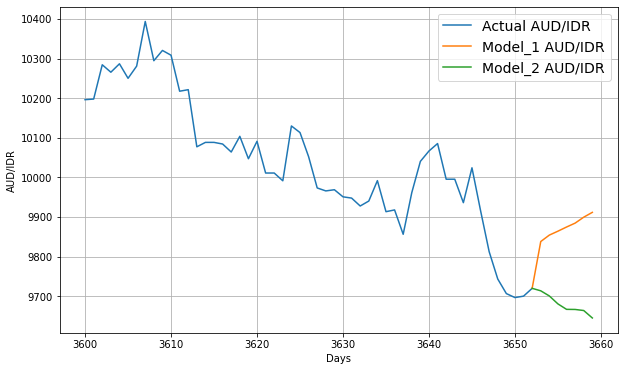

In [22]:
plt.figure(figsize=(10, 6))
plot_future_forecast(G.TIME, G.SERIES, start=3600, format="-", label="Actual AUD/IDR", xlabel="Days", ylabel="AUD/IDR")
plot_future_forecast(future_time, future_forecast_model_1, format="-", label="Model_1 AUD/IDR", xlabel="Days", ylabel="AUD/IDR")
plot_future_forecast(future_time, future_forecast_model_2, format="-", label="Model_2 AUD/IDR", xlabel="Days", ylabel="AUD/IDR")

## Compare model

In [23]:
model_results = pd.DataFrame({"model_5_layers": metrics_model_1,
                              "model_4_layers_regularized": metrics_model_2}).T

model_results

,mae,mse,rmse,mape
model_5_layers,338.237518,186806.87500,410.376923,3.260364
model_4_layers_regularized,332.434601,180286.28125,401.461487,3.187924
